# Lab 6 - Recurrent Neural Networks

In this lab, we will construct different kinds of recurrent neural networks with Keras and show how they many be used for classification, prediction and a little bit of fun. 

Recall that a recurrent neural network is any network with nodes that update their state between *prediction* runs. This is in contrast to a perceptron or CNN which only updates it state during training. A RNN is composted of __memory cells__, which hold a state between prediction runs, the most popular of which are LSTM and GRU cells. RNN's are trained by "unfolding" them to the desired input size, with the weights of each cell shared across the unfolding:

<img width=800px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Unroll.PNG">

There are four standard architectures for RNNs: 

<table><tr>
    <td><font size="4"><center>Many to Many</center></font></td><td><font size="4"><center>Many to Few</center></font></td>
    </tr><tr>
    <td style="padding-right: 5em;"><img width=300px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Type1.PNG"></td>
    <td><img width=300px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Type2.PNG"></td>
    </tr>
    <tr>
    <td><font size="4"><center>Few to Many</center></font></td><td><font size="4"><center>Variable to Variable</center></font></td>
    </tr><tr>
    <td style="padding-right: 5em;"><img width=300px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Type3.PNG"></td>
    <td><img width=300px src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20RNN%20Type4.PNG"></td>
    </tr>
</table>

This lab has three parts:

* Construct a __many to few__ RNN for the classification of text sentiment. We will be classifying the IMDB user comments database to see to see if reviews are positive or negative. 
* Use a __many to few/many__ RNN to forecast pollution levels in Beijing based on past weather data. 
* Finally, construct a few to many text generation engine using an RNN. 

This lab is based on Hands On Machine Learning With Scikit Learn, Tensorflow and Keras by Geron, and [Jason Brownlee's excellent tutorial on text generation with LSTM's](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/).

## IMDB User Sentiment and Many to One RNN's

First, we're going to build a many-to-one RNN, that is we take in many inputs but only record a single output. The dataset will be the IMDB review data set and we will be categorizing reviews as positively or negatively valanced. 

#### Understanding the Data

Before proceeding, we have to preprocess the data. The IMDB dataset has 50000 movies reviews from the Internet Movie Database, 25000 for training and 25000 for testing. Half of the reviews are positive (1) and half are negative (0). The words have already been processed into an integer index, with each word being represented by an integer. The translation diction is given by 

`word_to_id = imdb.get_word_index()`

which is a dictionary of `(word, int)` key-value pairs. Unfortunately this word list doesn't include __padding character__ `0`, the __start character__ `1` and the __unknown word character__ `2` so we have to shift the dictionary and manually add them.

In [1]:
from tensorflow.keras.datasets import imdb

NB_WORDS = 10000

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NB_WORDS)

word_to_id = imdb.get_word_index()
word_to_id = {k:(v+3) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2

1654784/1641221 [==============================] - 0s 0us/step


In [2]:
print("Test Proportion of labels \n 0's: {:.2f}, 1's: {:.2f}".format(y_test.mean(), 1-y_test.mean()))

Test Proportion of labels 
 0's: 0.50, 1's: 0.50


To form the id to word dictionary, we loop over the __(key, value)__ pairs and for a new dictionary of __(value,key)__ pairs using

`reverse_word_index = dict([(value, key) for (key, value) in word_to_id.items()])`

We can then decode a review, say `x_train[0]` by looping through the elements of `x_train[0]` and looking them up with `reverse_word_index`:

In [3]:
reverse_word_index = dict([(value, key) for (key, value) in word_to_id.items()])

review = [reverse_word_index[word] for word in x_train[0]]
' '.join(review)

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In this example, we will not be dynamically unrolling the RNN for training, but instead fix the maximum review length at 80 and pad any review with fewer than 80 characters. The `keras.preprocessing` library has a `sequence` class with utilities for dealing with sequences ([see the documentation for more information](https://keras.io/preprocessing/sequence/)). 

In [4]:
from tensorflow.keras.preprocessing import sequence

MAXLEN = 80
    
X_train = sequence.pad_sequences(x_train, maxlen=MAXLEN)
X_test = sequence.pad_sequences(x_test, maxlen=MAXLEN)

In [5]:
' '.join([reverse_word_index[i] for i in X_test[0]])

"<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> please give this one a miss br br <UNK> <UNK> and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite <UNK> so all you madison fans give this a miss"

#### Building the RNN
Now that we understand our data, lets build our RNN. To construct the RNN, we will have an embedding layer, densely connected to a layer of 32 LSTMs, densely connected to a single output node. Since this is a binary classification problem, we will use `binary_crossentropy`


* __The Embedding Layer:__ The embedding layer is itself a little neural network that we train to attempt to embed the high dimensional one-hot encoding of the text into a lower dimensional representation for ease of processing. Word2Vec is a two layer network that interpolates between the number of words `NB_WORDS` and the desired embedding dimension `EMBED_DIM`.  GloVec is an example of an unsupervised network that learns via taking the "context distance" between words in the training set and forming a Euclidean space. See [Jason Brownlees blog](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/) for more about word embeddings.

In the architecture below, Keras understands that since the dense layer is not a reccurence cell

In [6]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM
# model parameters:
EMBED_DIM = 50
LSTM_UNITS = 32

model = Sequential()

model.add(Embedding(NB_WORDS, EMBED_DIM, input_length=MAXLEN))
model.add(Dropout(0.2))
model.add(LSTM(LSTM_UNITS))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 50)            500000    
                                                                 
 dropout (Dropout)           (None, 80, 50)            0         
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________
None


Note that the vast majority of the variables for the network above come from the embedding layer.

#### Training

In [7]:
epochs = 10
validation_split = 0.2

history = model.fit(X_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Epoch 1/10
157/157 [==============================] - 10s 52ms/step - loss: 0.5067 - accuracy: 0.7524 - val_loss: 0.4242 - val_accuracy: 0.8044
Epoch 2/10
157/157 [==============================] - 8s 50ms/step - loss: 0.3307 - accuracy: 0.8611 - val_loss: 0.3516 - val_accuracy: 0.8410
Epoch 3/10
157/157 [==============================] - 7s 43ms/step - loss: 0.2756 - accuracy: 0.8910 - val_loss: 0.3846 - val_accuracy: 0.8402
Epoch 4/10
157/157 [==============================] - 7s 42ms/step - loss: 0.2441 - accuracy: 0.9037 - val_loss: 0.4065 - val_accuracy: 0.8210
Epoch 5/10
157/157 [==============================] - 6s 41ms/step - loss: 0.2221 - accuracy: 0.9145 - val_loss: 0.4754 - val_accuracy: 0.8204
Epoch 6/10
157/157 [==============================] - 7s 43ms/step - loss: 0.2052 - accuracy: 0.9228 - val_loss: 0.4995 - val_accuracy: 0.8300
Epoch 7/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1909 - accuracy: 0.9277 - val_loss: 0.3962 - val_accuracy: 0.837

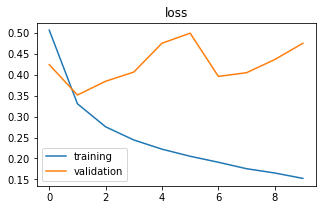

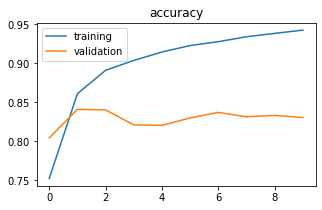

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['accuracy'], label='training')
plt.plot(history.epoch,history.history['val_accuracy'], label='validation')
plt.title('accuracy')
plt.legend(loc='best');

#### Exercise:

LSTMs often have problems with over fitting. Try adding another dropout layer between the LSTM and the output layer and compare with the results above.

#### Exercise:

Change the network above to be deeper, but thinner by adding another RNN layer both with 16 nodes. How do the loss accuracy, and training time compare to the first network?

## Many to Many RNN's: Forecasting Beijing's Polution Levels. 

Lets now take a look at time series data using a many to many RNN. We will follow closely the tutorial here:

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

We will be looking at the Beijing Air Quality dataset. The data set consists of labels


|Label|Description|Label|Description|
|-----|-----------|-----|-----------|
|No| row number|DEWP| Dew Point|
|year| year of data in this row|TEMP| Temperature|
|month| month of data in this row|PRES| Pressure|
|day| day of data in this row|cbwd| Combined wind direction|
|hour| hour of data in this row|Iws| Cumulated wind speed|
|pm2.5| PM2.5 concentration|Is| Cumulated hours of snow|
|Ir| Cumulated hours of rain|

In [9]:
import pandas as pd
data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv")
data.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Pandas can actually parse the date as it comes in by setting `parse_dates` to the fields containing dates and `date_parser`  to a function. Lets read the file in again parsing the year, month, day and hour using `datatime`. We'll also drop the `No` tag.

In [10]:
from datetime import datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv",  
                   parse_dates = [['year', 'month', 'day', 'hour']], 
                   index_col=0, 
                   date_parser=parse)
data.drop('No', axis=1, inplace=True)
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


We drop the `NaN`s in `pm2.5` by filling them with zeros using `.fillna(0, inplace=True)`. Then, we rename the column for readability. The data is now an index so we must set it with a different call.

In [11]:
data['pm2.5'].fillna(0, inplace=True)

data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
data.index.name = 'date'
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0


Lets take a look at our data:

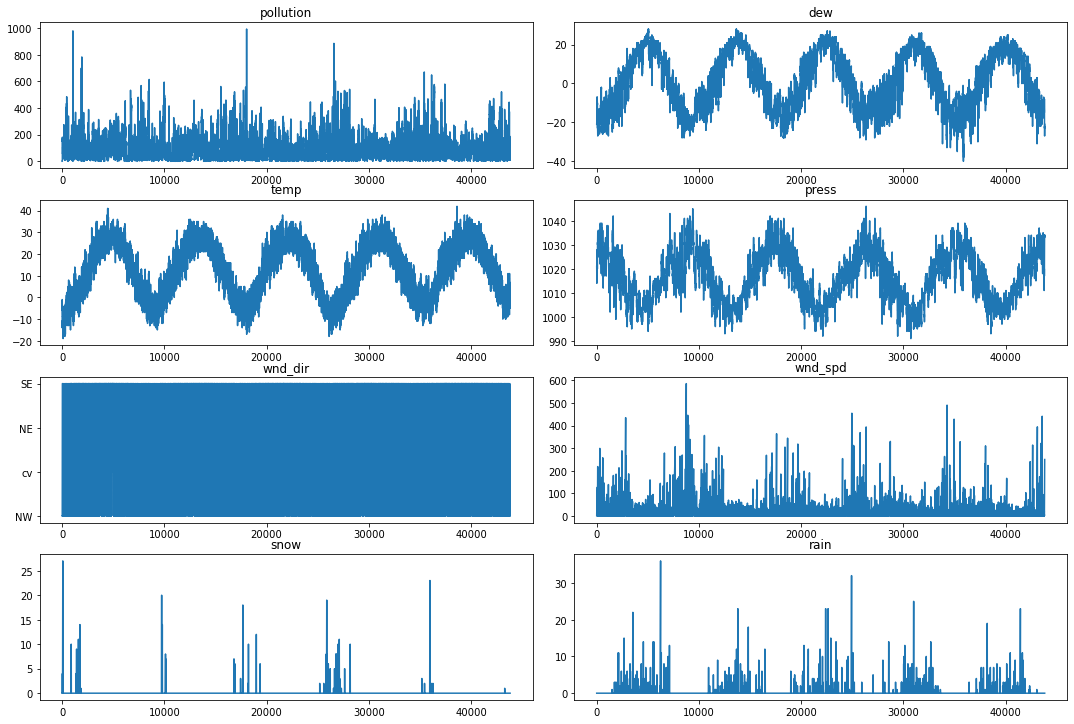

In [12]:
f, axes = plt.subplots(4,2,figsize=(15,10))
plt.tight_layout()

axes = axes.reshape(-1)

for i in range(8):
    axes[i].plot(data.values[:,i])
    axes[i].set_title(data.columns[i])

#### Training Data Preparation

We now need to prepare training data for the RNN to fit to. The data we construct will depend on the problem we are trying to solve. In this demonstration, we will formulate a network that solves the conditions for the pollution at the current hour, given the measurements at the previous time step. Some alternate formulations you could explore include:

* Predict the pollution for the next hour based on the weather conditions and pollution over the last 24 hours.
* Predict the pollution for the next hour as above and given the "expected" weather conditions for the next hour.

In [13]:
data.drop("wnd_dir", axis=1, inplace=True)

We scale the data so that all of the ranges are between 0 and 1.

In [14]:
from sklearn.preprocessing import MinMaxScaler

values = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(43824, 7)


Now, we will form sequences of data points, representing the five previous hours, and try to predict the weather the next hour. The easiest we to do this is to construct a new matrix by shifting the training data by one unit and concatanating the shifted matrices together along a new dimension:

<img width = 500 src="https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Lab%206%20Shiftdata.png">

This way of producing a training set of sequences from raw data is much faster than building the sequences using a loop. 

In [15]:
import numpy as np
SEQ_LEN = 5
DATA_LEN = scaled.shape[0]

X_train = scaled[0:-SEQ_LEN-1,:].reshape(-1,1,7)

for i in range(1,SEQ_LEN):
    X_train = np.append(X_train, scaled[i:-SEQ_LEN+i-1,:].reshape(-1,1,7), axis=1)
    
Y_train = scaled[SEQ_LEN:-1,0]
print(X_train.shape)

(43818, 5, 7)


Lets check that we've constructed out sequences correctly. For example, sequence 40 should contain data points 40 to 44 and the corresponding y should be the pollution from datapoint 45:

In [16]:
print(X_train[40,:,0])
print(Y_train[40])
print(scaled[40:46,0])

[0.15995976 0.16498994 0.17102616 0.1498994  0.15492958]
0.164989939637827
[0.15995976 0.16498994 0.17102616 0.1498994  0.15492958 0.16498994]


In [17]:
print(X_train.shape)
print(Y_train.shape)

(43818, 5, 7)
(43818,)


Now, lets built a model ad before. It will have an LSTM layer with 50 nodes that attach densely to a single output node. For loss we use __mean squared error__, but you can also try using __mean absolute error__.

In [18]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

Now, we run the model and plot the training and validation loss as before.

Epoch 1/100
274/274 [==============================] - 4s 7ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 2/100
274/274 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 8.7650e-04
Epoch 3/100
274/274 [==============================] - 1s 5ms/step - loss: 9.1679e-04 - val_loss: 6.6012e-04
Epoch 4/100
274/274 [==============================] - 1s 4ms/step - loss: 8.4553e-04 - val_loss: 6.6994e-04
Epoch 5/100
274/274 [==============================] - 1s 5ms/step - loss: 8.1890e-04 - val_loss: 6.1463e-04
Epoch 6/100
274/274 [==============================] - 1s 5ms/step - loss: 7.9465e-04 - val_loss: 5.8539e-04
Epoch 7/100
274/274 [==============================] - 1s 5ms/step - loss: 7.9823e-04 - val_loss: 5.8305e-04
Epoch 8/100
274/274 [==============================] - 1s 5ms/step - loss: 7.9668e-04 - val_loss: 6.2438e-04
Epoch 9/100
274/274 [==============================] - 1s 5ms/step - loss: 7.9252e-04 - val_loss: 6.1526e-04
Epoch 10/100
274/274 [=========

274/274 [==============================] - 1s 4ms/step - loss: 7.1987e-04 - val_loss: 5.6915e-04
Epoch 76/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1646e-04 - val_loss: 5.6456e-04
Epoch 77/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1571e-04 - val_loss: 5.9267e-04
Epoch 78/100
274/274 [==============================] - 1s 4ms/step - loss: 7.2160e-04 - val_loss: 5.6864e-04
Epoch 79/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1528e-04 - val_loss: 6.0018e-04
Epoch 80/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1405e-04 - val_loss: 5.8646e-04
Epoch 81/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1097e-04 - val_loss: 5.7745e-04
Epoch 82/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1141e-04 - val_loss: 5.9235e-04
Epoch 83/100
274/274 [==============================] - 1s 4ms/step - loss: 7.1424e-04 - val_loss: 5.7392e-04
Epoch 84/100
274/274 [=

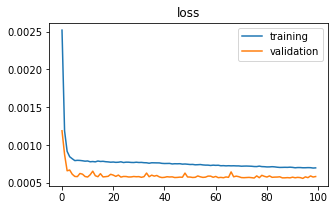

In [19]:
epochs = 100
validation_split = 0.2

history = model.fit(X_train, Y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'], label='training')
plt.plot(history.epoch,history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend(loc='best')

Let see how we did visually. We'll use the model to predict the next hour pollution levels on 40 or so data points and compare it to the actual next hour pollution.

In [20]:
A = np.array([])
OFFSET = 100
LEN = 40
for i in range(0,LEN):
    A = np.append(A,model.predict(X_train[OFFSET+i].reshape(1,5,7)))

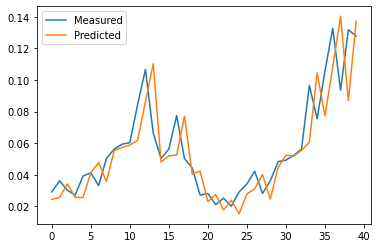

In [21]:
plt.plot(Y_train[OFFSET:OFFSET+LEN],label="Measured")
plt.plot(A,label="Predicted")
plt.legend()

### Exercise: 

Use the RNN to generate data: Starting with a training point, have the RNN predict the next hour pollution and then form a new test point by appending the prediction to the test point and dropping the last data point. Repeat this process until you've generated 200 hours of new data. 

Your generated data will not match up with the true pollution measurements unless you have massively over fit, but does it look reasonable?

### Exercise: Longer forcasting

Our results above aren't too shabby, that is until you zoom in farther. You may then find that the graph looks surprisingly  like the RNN has just learned to the current pollution level, albeit shifted slightly. Can we extend this forecast longer?

The only change we will need to make to our network is to output more nodes, specifically the number of hours ahead we want to predict. Create a new network, and new data, the predicts the next 5 hours. 

For more information on time series data generation we here: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# "Shall I generate thee a summers soliloquy?" 
## Text Generation with few to many RNNs

As a final step in RNN learning, lets build a text generation engine. A text generation engine is a few to many RNN, where we prime the network with a small snipit of text and ask it to generate more. For this engine, you can follow along with the copy of the complete works of Shakespeare, which can be found on the course blackboard, any book you have as a text file (Project Gutenburg has many https://www.gutenberg.org/) or any other large volume of text you have access to. 

This section closely follows https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/ where he performs a similar analysis on Alice in Wonderland. 

In [1]:
raw_text = open("Shakespeare.txt", encoding="utf8").read()
raw_text = raw_text.lower()

display(raw_text[0:1000])

'\ufeffthe project gutenberg ebook of the complete works of william shakespeare, by william shakespeare\n\nthis ebook is for the use of anyone anywhere in the united states and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. you may copy it, give it away or re-use it under the terms\nof the project gutenberg license included with this ebook or online at\nwww.gutenberg.org. if you are not located in the united states, you\nwill have to check the laws of the country where you are located before\nusing this ebook.\n\ntitle: the complete works of william shakespeare\n\nauthor: william shakespeare\n\nrelease date: january 1994 [ebook #100]\n[most recently updated: january 18, 2021]\n\nlanguage: english\n\ncharacter set encoding: utf-8\n\n\n*** start of the project gutenberg ebook the complete works of william shakespeare  ***\n\n\n\n\nthe complete works of william shakespeare\n\n\n\nby william shakespeare\n\n\n\n\n      contents\n\n\n\n               t

Notice that there are unfortunently line break throughout the document for formatting reasons. We could eliminate the line breaks keeping the paragraph, but for this RNN we only care about sequences of words. Lets replace all `\n` characters with spaces.

In [2]:
processed = raw_text.replace('\n',' ')
display(processed[0:1000])

'\ufeffthe project gutenberg ebook of the complete works of william shakespeare, by william shakespeare  this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever. you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org. if you are not located in the united states, you will have to check the laws of the country where you are located before using this ebook.  title: the complete works of william shakespeare  author: william shakespeare  release date: january 1994 [ebook #100] [most recently updated: january 18, 2021]  language: english  character set encoding: utf-8   *** start of the project gutenberg ebook the complete works of william shakespeare  ***     the complete works of william shakespeare    by william shakespeare           contents                   the sonnets                 all’s well th

We will start with a simple character level RNN. We can create a character map using the function `set()`:

* `set()` Converts a list in a set object. A set only contains one copy of each instance of the list. 

By converting the text to a set and then returning it to a list we get a list of all the characters in the novel:

In [3]:
chars = sorted(list(set(processed)))
print("Number of Characters:", len(chars))
print("Character Map:", chars)

Number of Characters: 79
Character Map: ['\t', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '@', '[', '\\', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '}', 'à', 'â', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'œ', '—', '‘', '’', '“', '”', '\ufeff']


We might want to process out the bit encoder mark `\ufeff`, as well as the odder special characters. In fact, for this first pass lets remove all nonstandard punctuation and numbers except tabs, brackets and quotes. 

In [4]:
bad_chars = ['&','\\','|', '}', '—', '‘', '’', '“', '”','0', '1', '2', '3', '4', '5', '6', '7', '8', '9','à', 'æ', 'è', 'œ', '\ufeff']
data = processed
for b in bad_chars:
    data = data.replace(b,'')

In [5]:
chars = sorted(list(set(data)))
print("Number of Characters:", len(chars))
print("Character Map:", chars)

Number of Characters: 55
Character Map: ['\t', ' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', ':', ';', '?', '@', '[', ']', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'ç', 'é', 'ê', 'ë', 'î']


Now, we generate a dataset of strings of a desired length, say 60 characters. We will also set a step size so that we take a subset of all possible strings.

In [6]:
STEP = 30
SEQ_LEN = 60

N_CHARS = len(data)

X_strings = []
y_next_chars = []

for i in range(0,N_CHARS - SEQ_LEN, STEP):
    X_strings.append(data[i:i+SEQ_LEN])
    y_next_chars.append(data[i+SEQ_LEN])
    
print("Number of sequencces: ", len(X_strings))
print(X_strings[0:5])
print(y_next_chars[0:5])

Number of sequencces:  184146
['the project gutenberg ebook of the complete works of william', ' the complete works of william shakespeare, by william shake', ' shakespeare, by william shakespeare  this ebook is for the ', 'speare  this ebook is for the use of anyone anywhere in the ', 'use of anyone anywhere in the united states and most other p']
[' ', 's', 'u', 'u', 'a']


Now, we one hot encode the vector using `enumerate`. The `index, value = enumerate(list)` function iterates through a list, returning both the index of each element and the value. We generate a matrix of 0's of the appropriate size and loop through put a 1 in the spot associated to each letter. 

In [7]:
import numpy as np

N_VOCAB = len(chars)

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

x = np.zeros((len(X_strings),SEQ_LEN,N_VOCAB),dtype=np.bool)
y = np.zeros((len(y_next_chars),N_VOCAB),dtype=np.bool)

for i, string in enumerate(X_strings):
    for t, char in enumerate(string):
        x[i,t, char_indices[char]] = 1
    y[i, char_indices[y_next_chars[i]]] = 1

Now, we will be making a sequential model with a a single LSTM layer connected to a dense layer with one node for each character. We then softmax the output to generate a probability vector of what character will come next. This will allow us to stochastically generate the next letter, adding a bit of diversity to the outcome. The last layer will use an Adam optimizer with categorical crossentropy.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import LambdaCallback, ModelCheckpoint

We will put 128 LSTM nodes in our model and attach them densely to a layer of perceptrons with one node for each character. We then softmax to normalize the output to a probability for each each letter. 

In [9]:
model = Sequential()
model.add(LSTM(124, input_shape=(SEQ_LEN,N_VOCAB)))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
#model.compile(loss=tf.nn.softmax_cross_entropy_with_logits_v2(), optimizer=optimizer)

We can optionally save out a model checkpoint if we want to store our fit weights until later (this may be wise for an RNN, it takes longer to train them than more linear networks). 

In [32]:
import sys
import io

# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model using our gpu

model.fit(x, y,
          batch_size=64,
          epochs=5,
          verbose=1)

Epoch 1/5
2878/2878 [==============================] - 173s 60ms/step - loss: 2.6397
Epoch 2/5
2878/2878 [==============================] - 169s 59ms/step - loss: 2.1057
Epoch 3/5
2878/2878 [==============================] - 149s 52ms/step - loss: 1.9898
Epoch 4/5
2878/2878 [==============================] - 147s 51ms/step - loss: 1.9062
Epoch 5/5
2878/2878 [==============================] - 160s 56ms/step - loss: 1.8551


Predicting on a sequence returns a vector of probabilities for each character. We want to define a function to sample the probability vector that we can tune a little bit to be more and less "creative." One way to do this is to scale the probabilities using

$$
\tilde{p}_i = \frac{\exp\left( \frac{1}{t}\log p_i \right)}{\sum_i e^{\frac1t\log p_i}} = \frac{p_i^{\frac{1}{t}}}{\sum_i p_i^{\frac{1}{t}}}\,.
$$

Increasing $t$ normalizes all the probabilities, bringing them closer together. We then use `np.random.multinomial` to randomly sample the probabilities, returning a 1 in the chosen index.

In [33]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [34]:
import random

sentence = data[50: 50 + SEQ_LEN]
diversity = 1
generated = ''
generated += sentence

for i in range(400):
    x_pred = np.zeros((1, SEQ_LEN, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, diversity)
    next_char = indices_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()

n i thee ack i seard; pith           why lusied and sichten you, carn ont ginglio, ampcels a sty cakpownat unourd?  intee._] till my grofrow, good htur villisar.  chirrim. winlor tith. i purbcon this voristing antes;   aplevante. heries xangly soun is dent deve pray emist i plocguress hil bolb. esterse, lidnt jowed my ling to uppe, betike!  though, ho that his levish fid his lisines folth our vilf

### Exercise: :

Repeat the code above using a GRU cell as opposed to a LSTM cell. Compare the training time and accuracy of the two networks.

## Problem 1:


There is nothing in principle different from the character level RNN above and a word level RNN. Make a RNN to generate sentences from words instead of characters (you may clean out all punctuation to make this easier). It may help to only use the words that appear more than one, more than twice or more than three times, dropping any phrases that include unique words. 

Construct a Shakespearian text generator using a word encoding rather than a letter by letter encoding. Compare the results of using LSTM vs GRU nodes. 

## Problem 2: (Geron, 15.10)

<img width = 800 src = http://www.bach-chorales.com/Images/ChoraleImages/Image_BWV_0133_6.jpg>

Download the [Bach chorales dataset](https://homl.info/bach) and unzip it. It is composed of 382 chorales composed by Johann Sebastian Bach. Each chorale is 100 to 640 time steps long, and each time step contains 4 integers, where each integer corresponds to a note’s index on a piano (except for the value 0, which means that no note is played).

Train a model — recurrent, convolutional, or both — that can predict the next time step (four notes), given a sequence of time steps from a chorale. Then use this model to generate Bach-like music, one note at a time: you can do this by giving the model the start of a chorale and asking it to predict the next time step, then appending these time steps to the input sequence and asking the model for the next note, and so on. Also make sure to check out [Google’s Coconet model](https://magenta.tensorflow.org/coconet), which was used for a nice Google doodle about Bach.

#### Further information

At each time step, each chorales has 4 notes. Looking at the CSV for one of  the files we see that the columns are __note0__, __note1__, __note2__ and __note3__, with each row corresponding to a timestep. Each of the numbers corresponds to a piano key. 

Python can construct audio and Jupyter can play it in a Jupyter widget:

In [ ]:
from IPython.display import Audio
import numpy as np
import pandas as pd

signal = np.random.random(750)
Audio(signal, rate=250)

The audio is then constructed by a simple sum of sine functions. I've uploaded in index between the note position and the keys taken from Wikipeidia (https://en.wikipedia.org/wiki/Piano_key_frequencies).

In [ ]:
piano_path = "https://raw.githubusercontent.com/tipthederiver/Math-7243-2020/master/Labs/Lab%206/Piano%20Notes.csv"
notes = pd.read_csv(piano_path, encoding= 'unicode_escape')
notes

We can then get the frequency from the key position by

In [ ]:
notes[notes["Key Position"]==1]

The function below will take a sequence of notes and turn it into audio.

In [ ]:
def gen_audio(song, notes, framerate=22050, L=.25):
    framerate = 22050  ## Standard Framerate
    N = len(song) # Number of Notes
    L = .25        # Note Length in Seconds
    W = int(framerate*L) # Window Size
    t = np.linspace(0,L,W)
    data = np.zeros(W*N)

    for i in range(N): 
        F = notes["Frequency (Hz)"].iloc[song[i]+1]
        data[W*i:W*(i+1)] = np.sin(2*np.pi*F*t)
        
    return data

 I've included two note snippets below. These are __note0__ and __note1__ from chorale 305:

In [ ]:
song_0 = [65,65,65,65,72,72,70,70,69,69,67,67,65,65,65,65,72,72,72,72,74,74,74,74,74,74,74]
song_1 = [60,60,60,60,60,60,60,60,60,60,60,60,62,62,64,64,65,65,65,65,65,65,65,65,65,65,65]

You can generate the tunes individually:

In [ ]:
data_0 = gen_audio(song_0, notes)
Audio(data,rate=22050)

or to hear them together, simply add the sine-wave representation:

In [ ]:
data_0 = gen_audio(song_0, notes)
data_1 = gen_audio(song_1, notes)
Audio(data_0 + data_1,rate=22050)

#### Rough Outline: 

This entire project can be completed without ever listening to the audio files and instead just treating the sequences as sequences. Your pattern should roughly be the text generator above, although now at each time step we have 4 notes, not a single letter. A rough outline is as follows:

* Load a single chorale using Panda's `read_csv` function.
* Construct the training data as we did for the text generator: the `X_train` will be sequences of $K$ timesteps, each time step containing the 4 notes. It is your choice if you leave them as integers of one-hot encode the notes. 
* The labels `y_train` will be sequences of length $K$ timesteps shifted by 1.
* Construct a simple RNN model with 64 LSTM nodes. Your input and output shape will be $K\times 4$ if you do not one-hot encode and $K\times 4\times 108$ if you do one-hot encode.
* After your get your network running on one chorale, expand your dataset by adding sequences from other chorales. 